In [1]:
import os
from jupyterthemes import jtplot
from matplotlib import pylab as plt
from matplotlib.pylab import rcParams
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

jtplot.style('oceans16')
sns.set(style='darkgrid', color_codes=True)
sns.set_context('talk')
sns.set_palette('dark')
rcParams['figure.figsize'] = (15, 5)
rcParams['savefig.pad_inches'] = 0.4
granularities = (
    'S5', 'S10', 'S15', 'S30', 'M1', 'M2', 'M3', 'M5', 'M10', 'M15', 'M30',
    'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12', 'D'
)[:12]

In [2]:
dict_dfs = {
    g: pd.read_csv('forex-sample-dataset/candle.{}.EUR_USD.csv'.format(g)).assign(
        time=lambda d: pd.to_datetime(d['time']),
        mid=lambda d: (d.closeAsk + d.closeBid) / 2
    ).assign(
        lr=lambda d: np.log(d.mid).diff()
    )[['time', 'mid', 'lr']] for g in granularities
}
df_mid = pd.concat([
    dict_dfs[g].drop(columns=['lr']).assign(granularity=g).reset_index()
    for g in granularities if g in dict_dfs
])
df_lr = pd.concat([
    dict_dfs[g].drop(columns=['mid']).assign(granularity=g).reset_index()
    for g in granularities if g in dict_dfs
])

Text(0.5, 0.98, 'EUR/USD mid points')

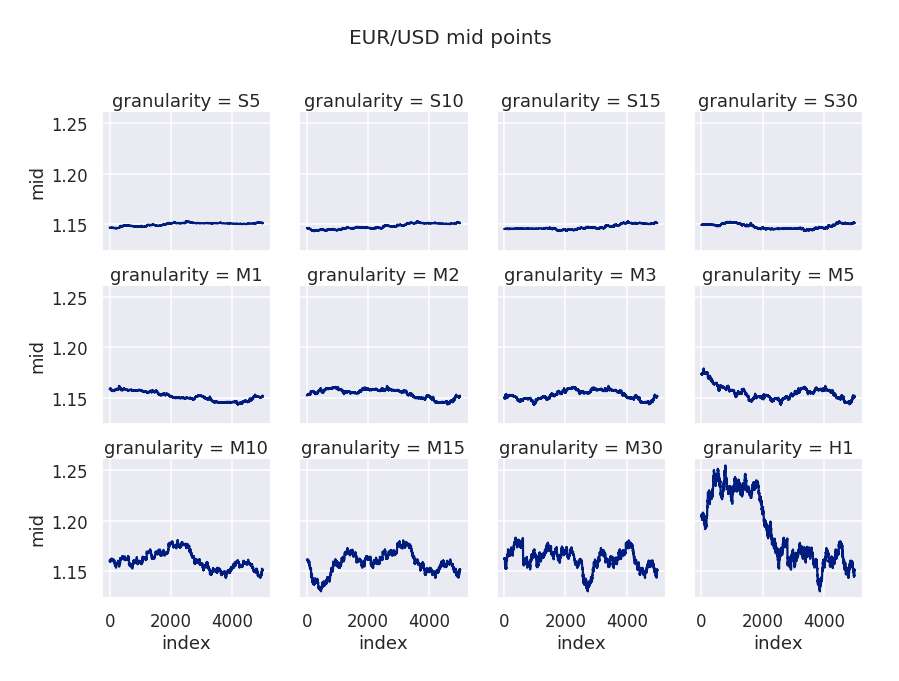

In [3]:
g1 = sns.FacetGrid(df_mid, col='granularity', col_wrap=4)
g1.map(sns.lineplot, 'index', 'mid')
g1.fig.subplots_adjust(top=0.85)
g1.fig.suptitle('EUR/USD mid points', fontsize='20')

Text(0.5, 0.98, 'EUR/USD log return')

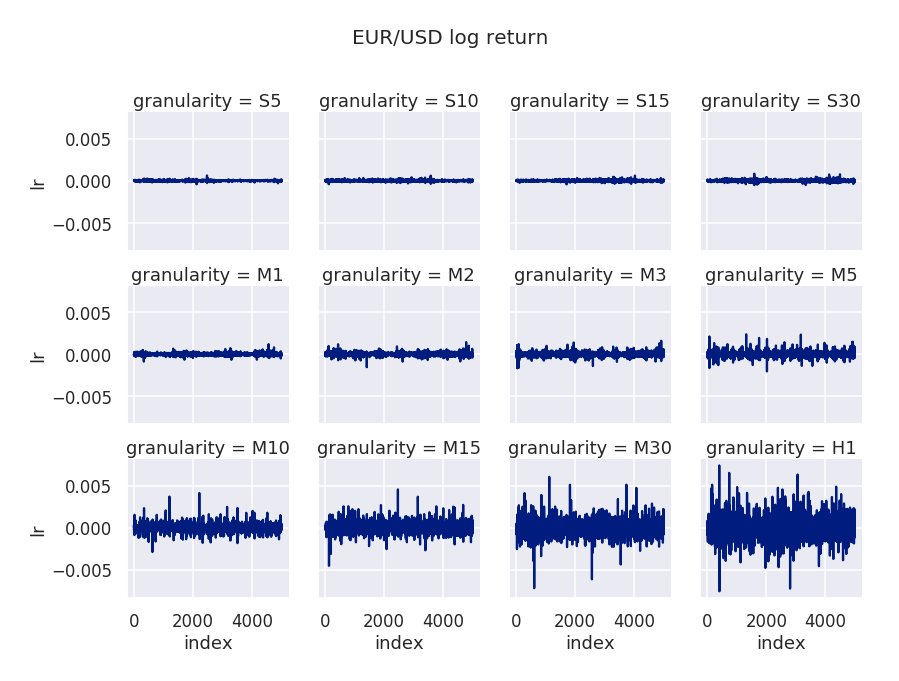

In [4]:
g2 = sns.FacetGrid(df_lr, col='granularity', col_wrap=4)
g2.map(sns.lineplot, 'index', 'lr')
g2.fig.subplots_adjust(top=0.85)
g2.fig.suptitle('EUR/USD log return', fontsize='20')

In [5]:
n_lags = 60
dict_lr = df_lr.dropna().sort_values('time').groupby('granularity').lr.apply(lambda s: s.tolist())
df_acf = pd.concat([
    pd.DataFrame({
        'granularity': k,
        'acf': sm.tsa.stattools.acf(dict_lr[k], nlags=n_lags),
        'pacf': sm.tsa.stattools.pacf(dict_lr[k], nlags=n_lags, method='ols')
    }).reset_index().iloc[1:] for k in granularities
])

Text(0.5, 0.98, 'EUR/USD log return autocorrelation')

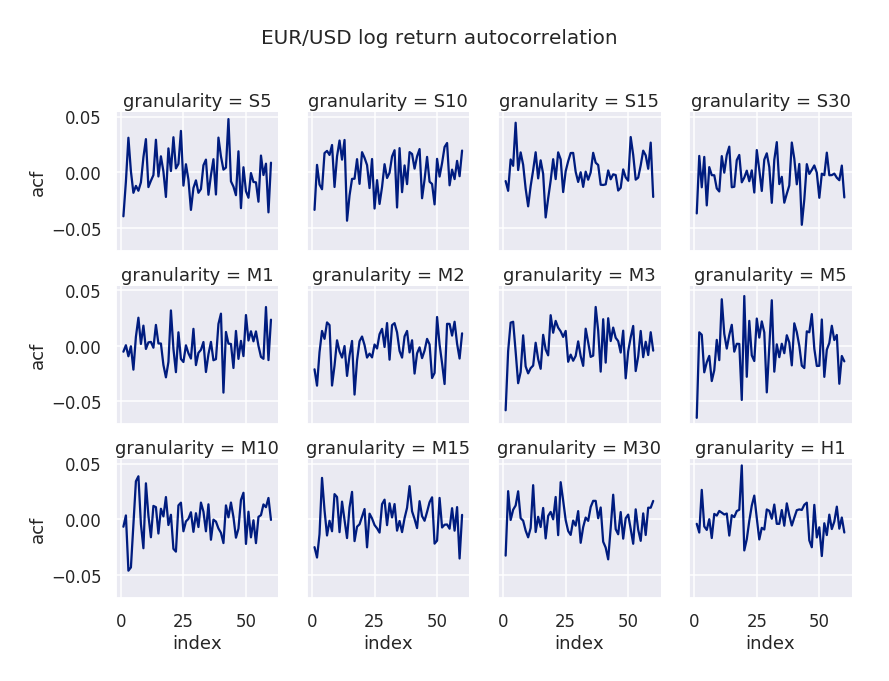

In [6]:
g3 = sns.FacetGrid(df_acf, col='granularity', col_wrap=4)
g3.map(sns.lineplot, 'index', 'acf')
g3.fig.subplots_adjust(top=0.85)
g3.fig.suptitle('EUR/USD log return autocorrelation', fontsize='20')

Text(0.5, 0.98, 'EUR/USD log return partial autocorrelation')

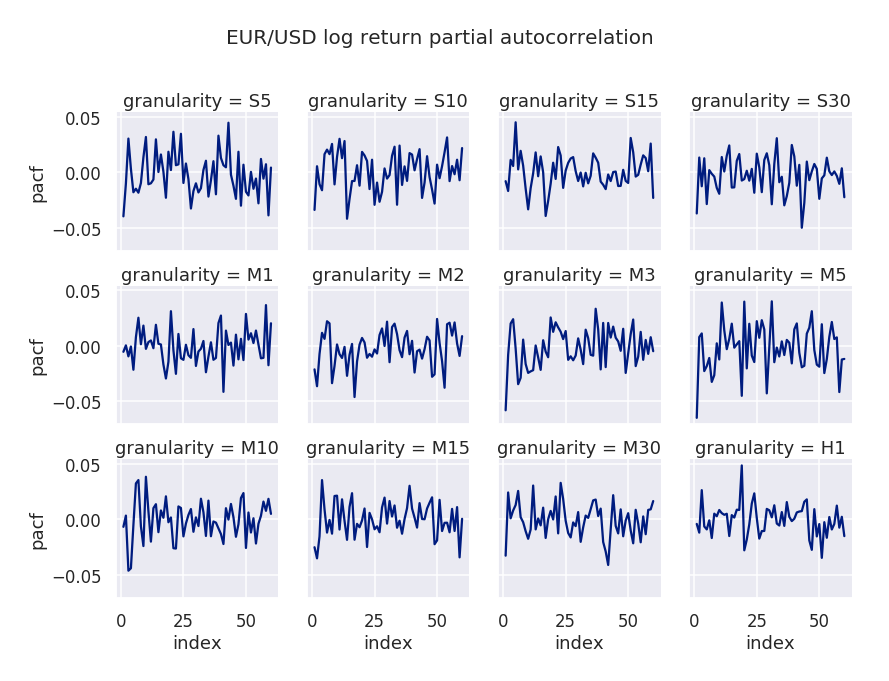

In [7]:
g4 = sns.FacetGrid(df_acf, col='granularity', col_wrap=4)
g4.map(sns.lineplot, 'index', 'pacf')
g4.fig.subplots_adjust(top=0.85)
g4.fig.suptitle('EUR/USD log return partial autocorrelation', fontsize='20')

In [8]:
df_ljungbox = pd.concat([
    pd.DataFrame({
        'granularity': k,
        'pvalue': sm.stats.diagnostic.acorr_ljungbox(x=dict_lr[k])[1]
    }).reset_index() for k in granularities
])
df_ljungbox.groupby('granularity')[['pvalue']].median().sort_values('pvalue')

,pvalue
granularity,
M5,2.811697e-07
M10,2.909309e-04
M3,5.896204e-04
S10,4.212680e-03
S5,1.065341e-02
M15,3.710392e-02
M2,4.583064e-02
S15,5.472264e-02
S30,1.156446e-01


In [9]:
df_ljungbox.groupby('granularity').median().pvalue.idxmin()

'M5'

Text(0.5, 0.98, 'Ljung-Box test for no autocorrelation of EUR/USD log return')

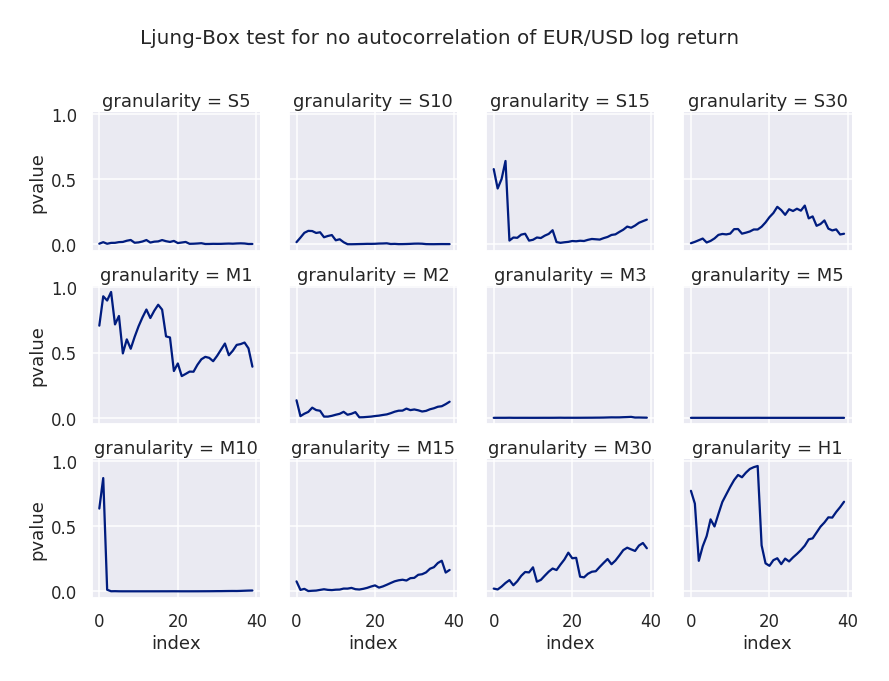

In [10]:
g5 = sns.FacetGrid(df_ljungbox, col='granularity', col_wrap=4)
g5.map(sns.lineplot, 'index', 'pvalue')
g5.fig.subplots_adjust(top=0.85)
g5.fig.suptitle('Ljung-Box test for no autocorrelation of EUR/USD log return', fontsize='20')